In [2]:
import numpy as np
import torch
import lightkurve as lk

print(f"NumPy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Lightkurve: {lk.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")

lc = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long")
print(f"Found {len(lc)} light curves for Kepler-10.")

c:\Users\mikem\source\repos\AIExoplanetFinder\.venv\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


NumPy: 2.4.1
PyTorch: 2.9.1+cpu
Lightkurve: 2.5.1
Found 15 light curves for Kepler-10.


In [3]:
import pandas as pd

url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+like+'%25Kepler%25'+and+default_flag=1&format=csv"
planets_df = pd.read_csv(url)

print(f"Found {len(planets_df)} confirmed Kepler planets")

Found 2783 confirmed Kepler planets


C:\Users\mikem\AppData\Local\Temp\ipykernel_56348\3084108069.py:4: DtypeWarning: Columns (3,184) have mixed types. Specify dtype option on import or set low_memory=False.
  planets_df = pd.read_csv(url)


Already exists: ../data/raw/kic_11904151.fits


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux'>

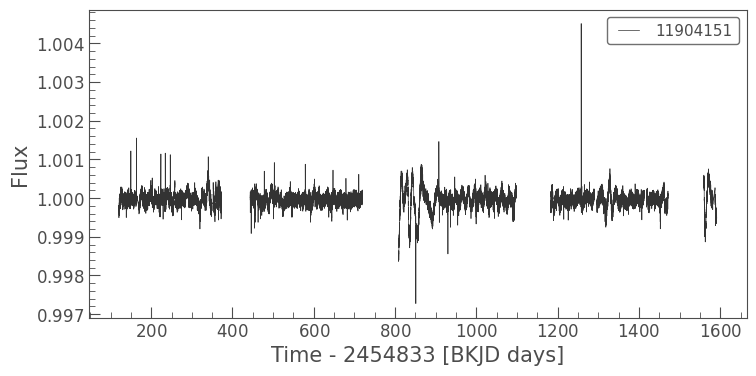

In [4]:
import lightkurve as lk
import os

# Create save directory (relative to notebook location)
SAVE_DIR = "../data/raw"
os.makedirs(SAVE_DIR, exist_ok=True)


def download_lightcurve(kepid):
    """Download and save a Kepler light curve."""
    
    filepath = f"{SAVE_DIR}/kic_{kepid}.fits"
    
    # Skip if already downloaded
    if os.path.exists(filepath):
        print(f"Already exists: {filepath}")
        return lk.read(filepath)
    
    # Search and download
    search = lk.search_lightcurve(f"KIC {kepid}", mission="Kepler", cadence="long")
    
    if len(search) == 0:
        print(f"Not found: KIC {kepid}")
        return None
    
    lc = search.download_all().stitch()
    lc.to_fits(filepath, overwrite=True)
    print(f"Saved: {filepath}")
    
    return lc


# Test
lc = download_lightcurve(11904151)  # Kepler-10
lc.plot()

In [5]:
# Sample Kepler IDs: confirmed planets
planet_kepids = [
    11904151,  # Kepler-10
    10797460,  # Kepler-22
    8191672,   # Kepler-16
    9941662,   # Kepler-36
    6922244,   # Kepler-62
]

# Download
for kepid in planet_kepids:
    download_lightcurve(kepid)
    print()

Already exists: ../data/raw/kic_11904151.fits

Already exists: ../data/raw/kic_10797460.fits

Already exists: ../data/raw/kic_8191672.fits

Already exists: ../data/raw/kic_9941662.fits

Already exists: ../data/raw/kic_6922244.fits



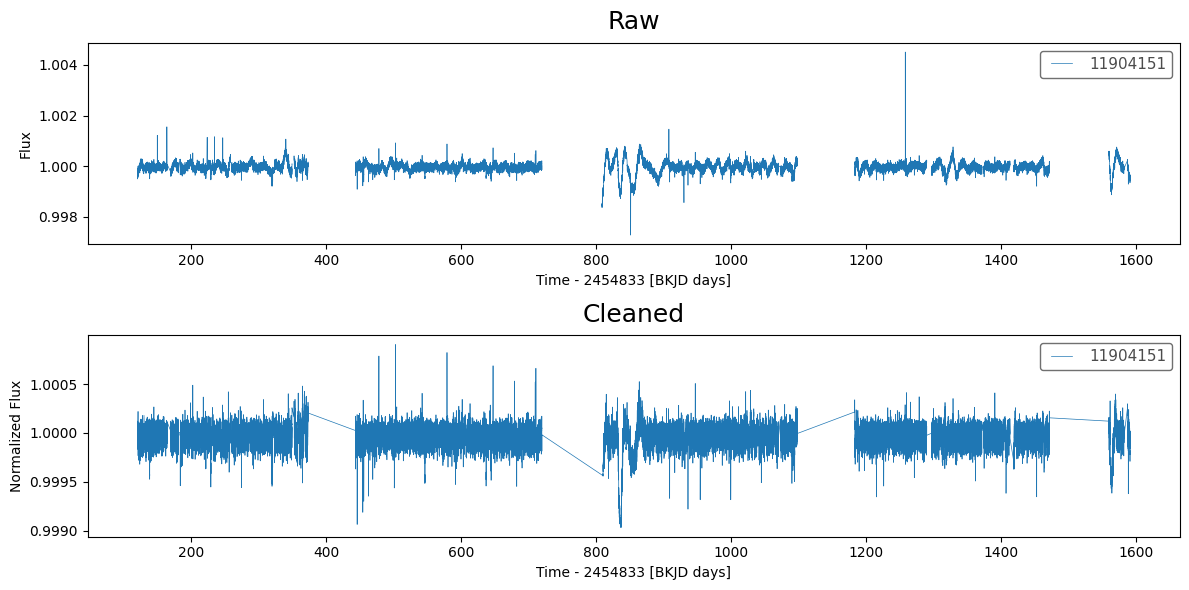

Points: 52195 → 51768


In [6]:
# Prepocessing one light curve
import matplotlib.pyplot as plt

# Load raw
lc_raw = lk.read("../data/raw/kic_11904151.fits")

# Clean
lc = lc_raw.remove_nans()
lc = lc.remove_outliers(sigma=5)
lc = lc.flatten(window_length=401)
lc = lc.normalize()

# Compare
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
lc_raw.plot(ax=axes[0], title="Raw")
lc.plot(ax=axes[1], title="Cleaned")
plt.tight_layout()
plt.show()

print(f"Points: {len(lc_raw)} → {len(lc)}")

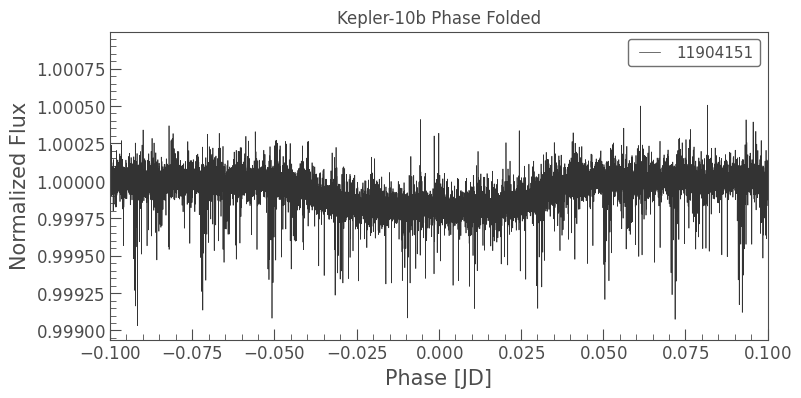

In [7]:
# Kepler-10b orbital period
period = 0.837495  # days
t0 = 131.57507    # first transit time (BKJD)

# Fold all transits onto each other
folded = lc.fold(period=period, epoch_time=t0)

# Plot
folded.plot()
plt.title("Kepler-10b Phase Folded")
plt.xlim(-0.1, 0.1)  # Zoom on transit
plt.show()

Shape: (2000,)
Mean: -0.0000, Std: 1.0000


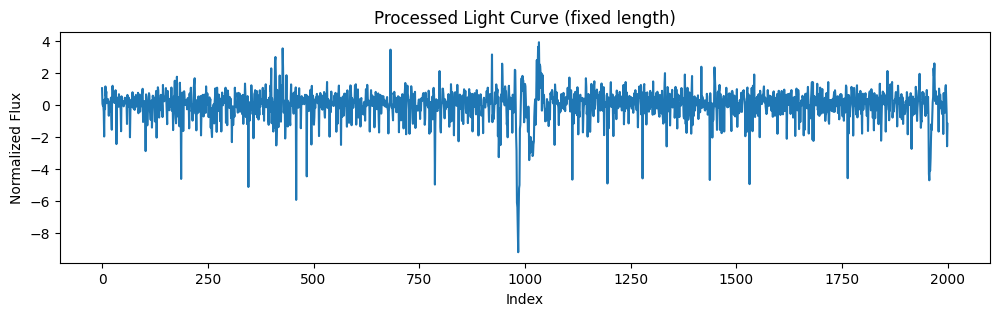

In [8]:
def process_lightcurve(filepath, period=None, t0=None, n_points=2000):
    """
    Load, clean, and convert light curve to fixed-length array.
    
    Parameters:
        filepath: Path to FITS file
        period: Orbital period (if known, will phase fold)
        t0: Epoch of first transit
        n_points: Output array length
    
    Returns:
        flux: numpy array of shape (n_points,)
    """
    
    # Load
    lc = lk.read(filepath)
    
    # Clean
    lc = lc.remove_nans()
    lc = lc.remove_outliers(sigma=5)
    lc = lc.flatten(window_length=401)
    lc = lc.normalize()
    
    # Phase fold if period known
    if period and t0:
        lc = lc.fold(period=period, epoch_time=t0)
    
    # Get flux values
    flux = lc.flux.value
    
    # Resample to fixed length
    from scipy.interpolate import interp1d
    x_old = np.linspace(0, 1, len(flux))
    x_new = np.linspace(0, 1, n_points)
    f = interp1d(x_old, flux, kind='linear', fill_value='extrapolate')
    flux_resampled = f(x_new)
    
    # Normalize to zero mean, unit variance
    flux_resampled = (flux_resampled - np.mean(flux_resampled)) / np.std(flux_resampled)
    
    return flux_resampled


# Test
flux = process_lightcurve("../data/raw/kic_11904151.fits")
print(f"Shape: {flux.shape}")
print(f"Mean: {flux.mean():.4f}, Std: {flux.std():.4f}")

plt.figure(figsize=(12, 3))
plt.plot(flux)
plt.title("Processed Light Curve (fixed length)")
plt.xlabel("Index")
plt.ylabel("Normalized Flux")
plt.show()

In [9]:
# More confirmed planets
planet_kepids = [
    11904151, 10797460, 8191672, 9941662, 6922244,   # Already have
    10593626, 3632418, 7040629, 8866102, 9002278,    # More planets
    5357901, 10874614, 6541920, 10227020, 5728139,
    7303287, 3861595, 9818381, 8684730, 10604335,
]

# False positives (eclipsing binaries) - these mimic transits
false_positive_kepids = [
    1026032, 1162635, 1432789, 1571511, 2162635,
    2302548, 2441495, 2576692, 2715264, 2849125,
    3098810, 3219434, 3339538, 3352358, 3453214,
    3558882, 3662635, 3735712, 3836439, 3935914,
]

print("Downloading planets...")
for kepid in planet_kepids:
    download_lightcurve(kepid)

print("\nDownloading false positives...")
for kepid in false_positive_kepids:
    download_lightcurve(kepid)

Already exists: ../data/raw/kic_11904151.fits
Already exists: ../data/raw/kic_10797460.fits
Already exists: ../data/raw/kic_8191672.fits
Already exists: ../data/raw/kic_9941662.fits
Already exists: ../data/raw/kic_6922244.fits
Already exists: ../data/raw/kic_10593626.fits
Already exists: ../data/raw/kic_3632418.fits
Already exists: ../data/raw/kic_7040629.fits
Already exists: ../data/raw/kic_8866102.fits
Already exists: ../data/raw/kic_9002278.fits
Already exists: ../data/raw/kic_5357901.fits
Already exists: ../data/raw/kic_10874614.fits
Already exists: ../data/raw/kic_6541920.fits
Already exists: ../data/raw/kic_10227020.fits
Already exists: ../data/raw/kic_5728139.fits
Already exists: ../data/raw/kic_7303287.fits
Already exists: ../data/raw/kic_3861595.fits
Already exists: ../data/raw/kic_9818381.fits
Already exists: ../data/raw/kic_8684730.fits
Already exists: ../data/raw/kic_10604335.fits

Already exists: ../data/raw/kic_1026032.fits
Already exists: ../data/raw/kic_1162635.fits
Alr

Could not resolve "KIC 2715264" to a sky position.


Not found: KIC 2715264
Already exists: ../data/raw/kic_2849125.fits
Already exists: ../data/raw/kic_3098810.fits


Could not resolve "KIC 3219434" to a sky position.


Not found: KIC 3219434
Already exists: ../data/raw/kic_3339538.fits


Could not resolve "KIC 3352358" to a sky position.


Not found: KIC 3352358
Already exists: ../data/raw/kic_3453214.fits


Could not resolve "KIC 3558882" to a sky position.


Not found: KIC 3558882
Already exists: ../data/raw/kic_3662635.fits


Could not resolve "KIC 3735712" to a sky position.


Not found: KIC 3735712
Already exists: ../data/raw/kic_3836439.fits
Already exists: ../data/raw/kic_3935914.fits


In [10]:
import os
import numpy as np

def build_dataset(planet_kepids, fp_kepids, n_points=2000):
    """
    Create X (features) and y (labels) arrays.
    
    Labels: 1 = planet, 0 = not planet
    """
    
    X = []
    y = []
    kepids = []
    
    # Process planets (label = 1)
    for kepid in planet_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(1)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    # Process false positives (label = 0)
    for kepid in fp_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(0)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, kepids


# Build dataset
X, y, kepids = build_dataset(planet_kepids, false_positive_kepids)

print(f"Dataset shape: {X.shape}")
print(f"Labels: {len(y[y==1])} planets, {len(y[y==0])} non-planets")

# Save for later
np.save("../data/processed/X.npy", X)
np.save("../data/processed/y.npy", y)
print("Saved to data/processed/")

Dataset shape: (35, 2000)
Labels: 20 planets, 15 non-planets
Saved to data/processed/


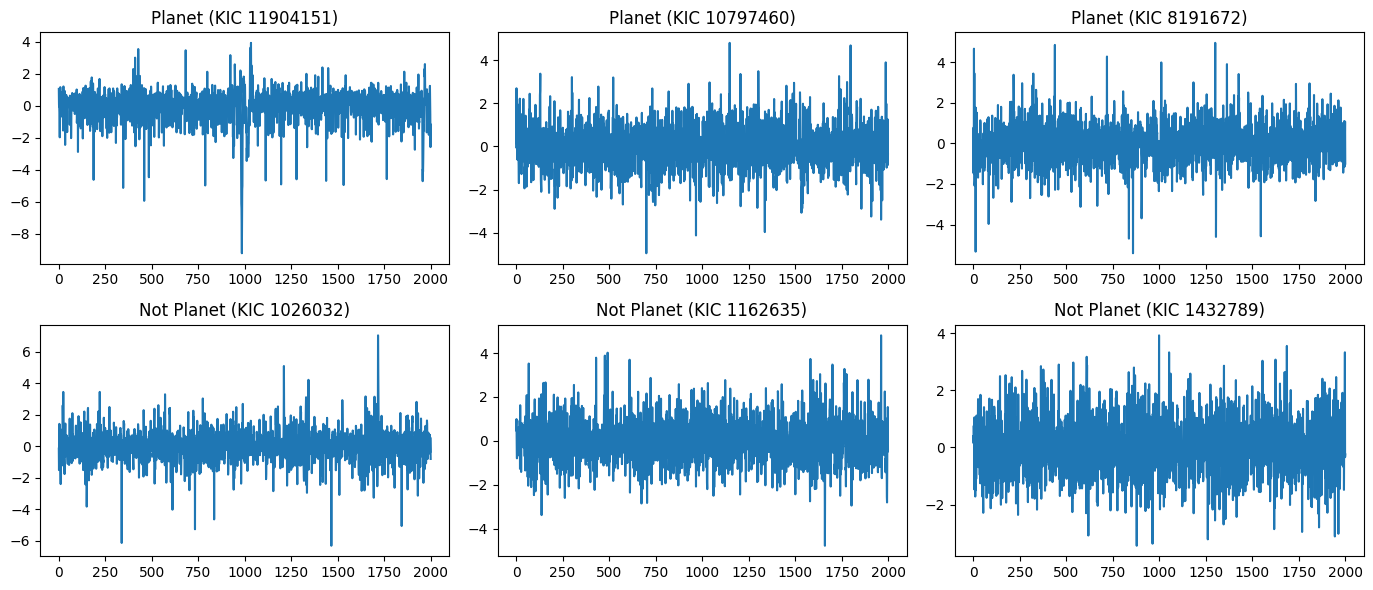

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# Plot 3 planets
planet_idx = np.where(y == 1)[0][:3]
for i, idx in enumerate(planet_idx):
    axes[0, i].plot(X[idx])
    axes[0, i].set_title(f"Planet (KIC {kepids[idx]})")

# Plot 3 non-planets
fp_idx = np.where(y == 0)[0][:3]
for i, idx in enumerate(fp_idx):
    axes[1, i].plot(X[idx])
    axes[1, i].set_title(f"Not Planet (KIC {kepids[idx]})")

plt.tight_layout()
plt.show()

In [12]:
# Old API endpoint
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=q1_q17_dr25_tce&select=kepid,tce_period,tce_depth,tce_duration,av_training_set&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df.head())

Rows: 34032
     kepid  tce_period  tce_depth  tce_duration  av_training_set
0  2304168  431.719000    488.400        13.220              NaN
1  2304235    0.570607     75.150         1.160              NaN
2  2304566    0.689480      3.794         5.236              NaN
3  2304320   16.540800    366.700         2.715              NaN
4  2303365    0.520697    123.600         1.035              NaN


In [13]:
import pandas as pd

# Get confirmed planets
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,koi_period,koi_depth,koi_duration,koi_disposition&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df['koi_disposition'].value_counts())
print(df.head())

Rows: 9564
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
      kepid  koi_period  koi_depth  koi_duration koi_disposition
0  10797460    9.488036      615.8       2.95750       CONFIRMED
1  10797460   54.418383      874.8       4.50700       CONFIRMED
2  10811496   19.899140    10829.0       1.78220       CANDIDATE
3  10848459    1.736952     8079.2       2.40641  FALSE POSITIVE
4  10854555    2.525592      603.3       1.65450       CONFIRMED


In [14]:
# Create labels: 1 = confirmed planet, 0 = false positive
# Drop candidates (uncertain)
df_labeled = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df_labeled['label'] = (df_labeled['koi_disposition'] == 'CONFIRMED').astype(int)

# Features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration']
df_labeled = df_labeled.dropna(subset=feature_cols)

X = df_labeled[feature_cols].values
y = df_labeled['label'].values

print(f"X shape: {X.shape}")
print(f"Planets: {sum(y==1)}, False positives: {sum(y==0)}")

X shape: (7326, 3)
Planets: 2744, False positives: 4582


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 5860, Test: 1466


In [16]:
import os

os.makedirs("../data/processed", exist_ok=True)
np.save("../data/processed/X_train.npy", X_train)
np.save("../data/processed/X_test.npy", X_test)
np.save("../data/processed/y_train.npy", y_train)
np.save("../data/processed/y_test.npy", y_test)

print("Saved.")

Saved.


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset class
class ExoplanetDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 184
Test batches: 46


In [18]:
class ExoplanetNN(nn.Module):
    def __init__(self, input_size=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

model = ExoplanetNN()
print(model)

ExoplanetNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [19]:
# Setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Forward
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

print("Training complete.")

Epoch 10/50, Loss: 0.4385
Epoch 20/50, Loss: 0.4152
Epoch 30/50, Loss: 0.3984
Epoch 40/50, Loss: 0.3908
Epoch 50/50, Loss: 0.3820
Training complete.


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Accuracy:  0.8090
Precision: 0.7291
Recall:    0.7796
F1 Score:  0.7535

Confusion Matrix:
[[758 159]
 [121 428]]


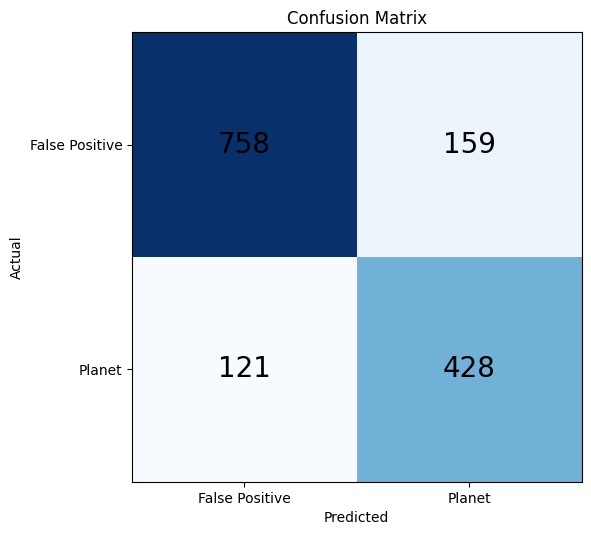

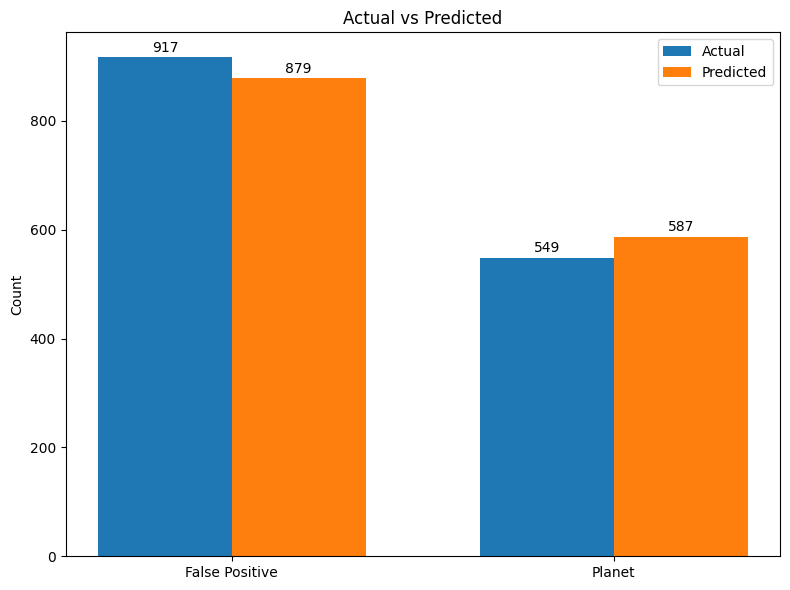

In [21]:
import matplotlib.pyplot as plt


# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['False Positive', 'Planet'])
ax.set_yticklabels(['False Positive', 'Planet'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add numbers
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.show()

# Count actual vs predicted
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

# Bar chart
labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add numbers on bars
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

In [22]:
# Save model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/exoplanet_nn.pt")
print("Model saved.")

Model saved.


In [23]:
print("Beginning model improvements")


Beginning model improvements


In [24]:
class ExoplanetNNv2(nn.Module):
    def __init__(self, input_size=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train v2
model_v2 = ExoplanetNNv2()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.001)

for epoch in range(100):
    model_v2.train()
    for X_batch, y_batch in train_loader:
        outputs = model_v2(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

# Evaluate v2
model_v2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v2(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"\nV2 Results:")
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")

Epoch 20/100, Loss: 0.6637
Epoch 40/100, Loss: 0.0518
Epoch 60/100, Loss: 0.1876
Epoch 80/100, Loss: 0.5435
Epoch 100/100, Loss: 0.1670

V2 Results:
Accuracy:  0.8186
Precision: 0.7411
Recall:    0.7923
F1 Score:  0.7658


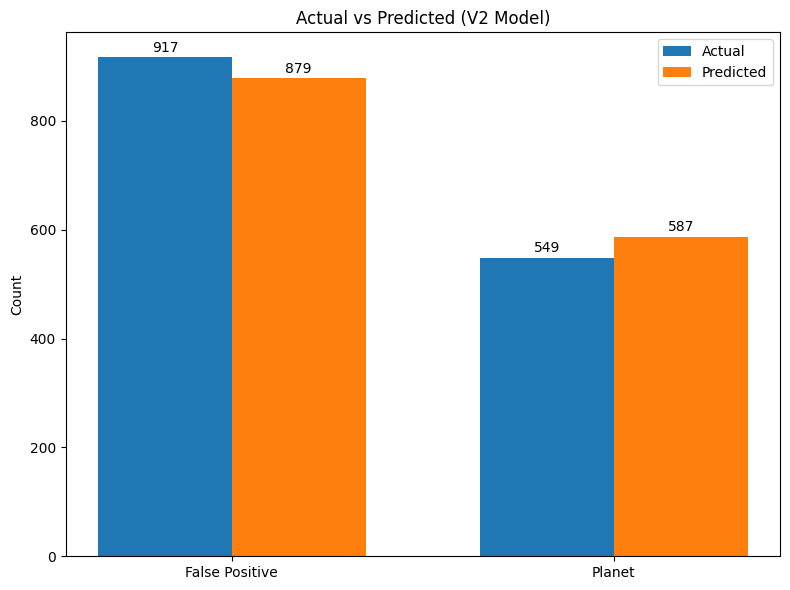

In [25]:
# Bar chart comparison
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted (V2 Model)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

In [26]:
torch.save(model_v2.state_dict(), "../models/exoplanet_nn_v2.pt")
print("V2 model saved.")

V2 model saved.


In [27]:
print("Adding more planet features to improve model performance.")

Adding more planet features to improve model performance.


In [28]:
# Get more features
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,koi_period,koi_depth,koi_duration,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_model_snr,koi_disposition&format=csv"

df = pd.read_csv(f"{url}?{params}")

# Filter and create labels
df = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df['label'] = (df['koi_disposition'] == 'CONFIRMED').astype(int)

# More features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 
                'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
df = df.dropna(subset=feature_cols)

X = df[feature_cols].values
y = df['label'].values

print(f"X shape: {X.shape}")
print(f"Planets: {sum(y==1)}, FP: {sum(y==0)}")

X shape: (7326, 9)
Planets: 2744, FP: 4582


In [29]:
print("Retraining model with additional features...")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Retraining model with additional features...
Train: 5860, Test: 1466
Features: 9


In [30]:
class ExoplanetNNv3(nn.Module):
    def __init__(self, input_size=9):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train
model_v3 = ExoplanetNNv3(input_size=9)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_v3.parameters(), lr=0.001)

for epoch in range(100):
    model_v3.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_v3(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {total_loss/len(train_loader):.4f}")

Epoch 20/100, Loss: 0.3778
Epoch 40/100, Loss: 0.3429
Epoch 60/100, Loss: 0.3426
Epoch 80/100, Loss: 0.3271
Epoch 100/100, Loss: 0.3120


In [31]:
model_v3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v3(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"\nV3 Results (9 features):")
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")


V3 Results (9 features):
Accuracy:  0.8445
Precision: 0.7512
Recall:    0.8743
F1 Score:  0.8081


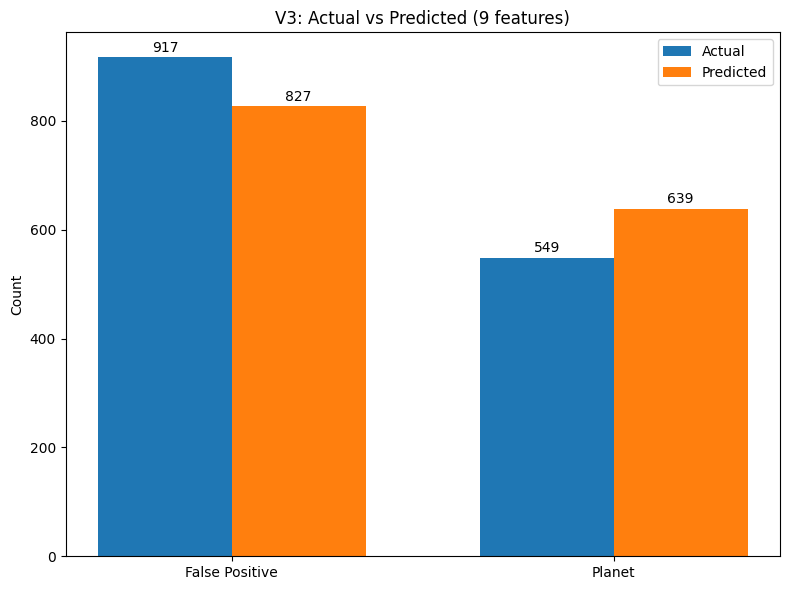


Confusion Matrix:
[[758 159]
 [ 69 480]]


In [32]:
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('V3: Actual vs Predicted (9 features)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

In [33]:
# Try different thresholds
model_v3.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v3(X_batch)
        all_probs.extend(outputs.numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("Threshold | Accuracy | Precision | Recall | F1")
print("-" * 50)
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    preds = (all_probs > thresh).astype(float)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds)
    rec = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    print(f"   {thresh}     |  {acc:.4f}  |  {prec:.4f}   | {rec:.4f} | {f1:.4f}")

Threshold | Accuracy | Precision | Recall | F1
--------------------------------------------------
   0.3     |  0.8206  |  0.6852   | 0.9636 | 0.8009
   0.4     |  0.8370  |  0.7153   | 0.9381 | 0.8117
   0.5     |  0.8445  |  0.7512   | 0.8743 | 0.8081
   0.6     |  0.8329  |  0.7764   | 0.7778 | 0.7771
   0.7     |  0.8035  |  0.8145   | 0.6157 | 0.7012


In [34]:
# Save model
torch.save(model_v3.state_dict(), "../models/exoplanet_nn_v3.pt")

# Save scaler for future predictions
import pickle
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved.")
print("Optimal threshold: 0.7")

Model and scaler saved.
Optimal threshold: 0.7


                      Model  Accuracy  Precision  Recall     F1
            V1 (3 features)    0.8076     0.7251  0.7832 0.7531
            V2 (3 features)    0.8165     0.7303  0.8087 0.7675
V3 (9 features, thresh=0.7)    0.8581     0.7541  0.9217 0.8295


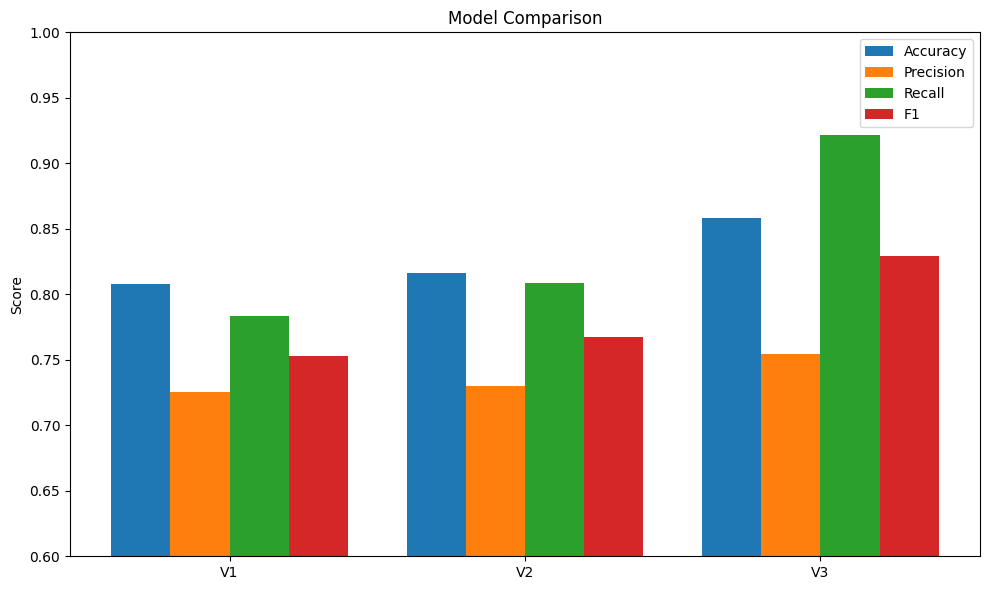

In [35]:
results = {
    'Model': ['V1 (3 features)', 'V2 (3 features)', 'V3 (9 features, thresh=0.7)'],
    'Accuracy': [0.8076, 0.8165, 0.8581],
    'Precision': [0.7251, 0.7303, 0.7541],
    'Recall': [0.7832, 0.8087, 0.9217],
    'F1': [0.7531, 0.7675, 0.8295]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.2

ax.bar(x - 1.5*width, results['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, results['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, results['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, results['F1'], width, label='F1')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['V1', 'V2', 'V3'])
ax.legend()
ax.set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()

In [36]:
import pickle

def predict_planet(features, threshold=0.7):
    """
    Predict if features indicate a planet.
    
    Parameters:
        features: dict with keys: koi_period, koi_depth, koi_duration, 
                  koi_prad, koi_teq, koi_insol, koi_steff, koi_srad, koi_model_snr
        threshold: classification threshold (default 0.7)
    
    Returns:
        prediction: 'Planet' or 'False Positive'
        probability: model confidence
    """
    
    # Load scaler
    with open("../models/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    
    # Load model
    model = ExoplanetNNv3(input_size=9)
    model.load_state_dict(torch.load("../models/exoplanet_nn_v3.pt"))
    model.eval()
    
    # Prepare features
    feature_order = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad',
                     'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
    X = np.array([[features[f] for f in feature_order]])
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    
    # Predict
    with torch.no_grad():
        prob = model(X).item()
    
    prediction = "Planet" if prob > threshold else "False Positive"
    
    return prediction, prob


# Test with a real example from our data
test_example = {
    'koi_period': 9.488,
    'koi_depth': 615.8,
    'koi_duration': 2.957,
    'koi_prad': 2.35,
    'koi_teq': 585.0,
    'koi_insol': 27.5,
    'koi_steff': 5627.0,
    'koi_srad': 1.06,
    'koi_model_snr': 45.2
}

pred, prob = predict_planet(test_example)
print(f"Prediction: {pred}")
print(f"Probability: {prob:.4f}")

Prediction: Planet
Probability: 0.8370


In [37]:
# Get candidates (unconfirmed)
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,kepoi_name,koi_period,koi_depth,koi_duration,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_model_snr,koi_disposition&format=csv"

df_all = pd.read_csv(f"{url}?{params}")

# Filter to candidates only
df_candidates = df_all[df_all['koi_disposition'] == 'CANDIDATE'].copy()

# Drop rows with missing features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad',
                'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
df_candidates = df_candidates.dropna(subset=feature_cols)

print(f"Candidates to predict: {len(df_candidates)}")
print(df_candidates.head())

Candidates to predict: 1875
       kepid kepoi_name  koi_period  koi_depth  koi_duration  koi_prad  \
2   10811496  K00753.01   19.899140    10829.0        1.7822     14.60   
58  11818800  K00777.01   40.419504     6256.0        3.3620      7.51   
62  11918099  K00780.02    7.240661      556.4        0.5580     19.45   
63   9579641  K00115.03    3.435916       23.2        3.1330      0.55   
84   3115833  K00797.01   10.181584     5741.1        3.5089      7.73   

    koi_teq  koi_insol  koi_steff  koi_srad  koi_model_snr koi_disposition  
2     638.0      39.30     5853.0     0.868           76.3       CANDIDATE  
58    467.0      11.29     5446.0     0.781           36.9       CANDIDATE  
62    734.0      68.63     5005.0     0.765           13.7       CANDIDATE  
63   1272.0     617.61     5779.0     1.087            8.7       CANDIDATE  
84    812.0     102.91     5988.0     0.836          183.6       CANDIDATE  


In [38]:
# Prepare features
X_candidates = df_candidates[feature_cols].values
X_candidates_scaled = scaler.transform(X_candidates)
X_tensor = torch.tensor(X_candidates_scaled, dtype=torch.float32)

# Predict
model_v3.eval()
with torch.no_grad():
    probabilities = model_v3(X_tensor).numpy()

# Add predictions to dataframe
df_candidates['planet_probability'] = probabilities
df_candidates['prediction'] = (probabilities > 0.7).astype(int)
df_candidates['prediction_label'] = df_candidates['prediction'].map({1: 'Likely Planet', 0: 'Likely False Positive'})

print(f"\nPredictions:")
print(df_candidates['prediction_label'].value_counts())


Predictions:
prediction_label
Likely False Positive    1202
Likely Planet             673
Name: count, dtype: int64


In [39]:
# Sort by probability
df_likely_planets = df_candidates.sort_values('planet_probability', ascending=False)

print("Top 15 Most Likely Planets:")
print(df_likely_planets[['kepoi_name', 'koi_period', 'koi_prad', 'planet_probability']].head(15).to_string(index=False))

Top 15 Most Likely Planets:
kepoi_name  koi_period  koi_prad  planet_probability
 K03444.04   14.150231      0.74            0.884572
 K06513.01    5.622411      1.17            0.882693
 K05327.01    5.433613      2.09            0.882640
 K08012.01   34.573719      0.42            0.880085
 K01843.02    6.355857      0.86            0.879401
 K03102.01    9.321084      0.61            0.879346
 K02862.01   24.575252      1.64            0.878216
 K01397.01    6.247031      1.89            0.877891
 K06752.01    8.942965      0.89            0.877775
 K06925.01   12.948926      0.94            0.876279
 K02453.01    1.530515      0.84            0.875788
 K03034.01   31.020917      1.66            0.875775
 K04957.02    4.987924      0.73            0.875414
 K04097.02    4.449023      0.55            0.873287
 K00531.01    3.687470      5.78            0.872267


In [40]:
# Near the decision boundary
df_uncertain = df_candidates[
    (df_candidates['planet_probability'] > 0.5) & 
    (df_candidates['planet_probability'] < 0.8)
].sort_values('planet_probability', ascending=False)

print(f"\nUncertain cases ({len(df_uncertain)}):")
print(df_uncertain[['kepoi_name', 'koi_period', 'koi_prad', 'planet_probability']].head(10).to_string(index=False))


Uncertain cases (746):
kepoi_name  koi_period  koi_prad  planet_probability
 K03318.02   25.697069      3.83            0.799858
 K06130.01    1.542874      1.05            0.799267
 K04774.01   51.567801      1.30            0.799214
 K04009.02   77.792718      2.17            0.798204
 K05359.01    2.720020      1.53            0.798085
 K02722.05   16.534002      1.17            0.797438
 K04451.01    8.830368      1.32            0.797434
 K05479.01   18.347081      5.65            0.797231
 K03313.01   34.952426     21.74            0.796913
 K06178.01   13.032730      1.64            0.796672


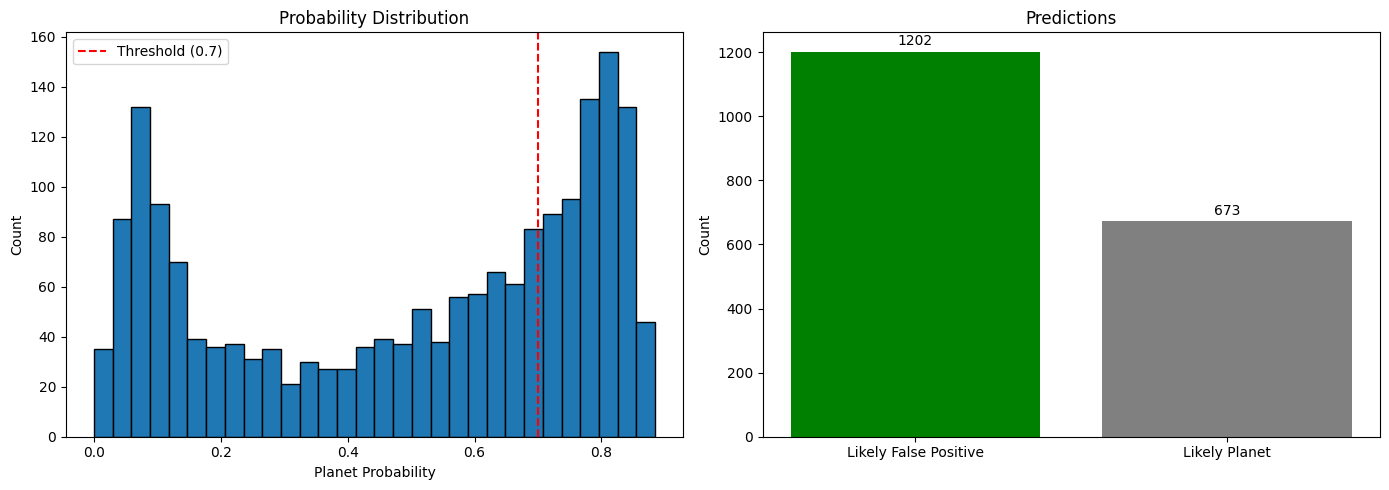

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of probabilities
axes[0].hist(df_candidates['planet_probability'], bins=30, edgecolor='black')
axes[0].axvline(x=0.7, color='red', linestyle='--', label='Threshold (0.7)')
axes[0].set_xlabel('Planet Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Probability Distribution')
axes[0].legend()

# Prediction counts
counts = df_candidates['prediction_label'].value_counts()
axes[1].bar(counts.index, counts.values, color=['green', 'gray'])
axes[1].set_ylabel('Count')
axes[1].set_title('Predictions')
for i, v in enumerate(counts.values):
    axes[1].text(i, v + 20, str(v), ha='center')

plt.tight_layout()
plt.show()

In [42]:
# Compare likely planets vs likely false positives
likely_planets = df_candidates[df_candidates['prediction'] == 1]
likely_fp = df_candidates[df_candidates['prediction'] == 0]

print("Feature Comparison (median values):")
print(f"\n{'Feature':<20} {'Likely Planets':>15} {'Likely FP':>15}")
print("-" * 52)

for col in feature_cols:
    planet_med = likely_planets[col].median()
    fp_med = likely_fp[col].median()
    print(f"{col:<20} {planet_med:>15.2f} {fp_med:>15.2f}")

Feature Comparison (median values):

Feature               Likely Planets       Likely FP
----------------------------------------------------
koi_period                     12.50           40.69
koi_depth                     228.30          263.30
koi_duration                    2.93            4.43
koi_prad                        1.38            2.08
koi_teq                       717.00          658.00
koi_insol                      62.51           44.30
koi_steff                    5548.00         5850.00
koi_srad                        0.86            1.12
koi_model_snr                  10.70           11.30


In [43]:
# Save to CSV
output_cols = ['kepoi_name', 'kepid', 'koi_period', 'koi_prad', 'planet_probability', 'prediction_label']
df_candidates[output_cols].to_csv("../results/candidate_predictions.csv", index=False)

print("Saved to results/candidate_predictions.csv")

Saved to results/candidate_predictions.csv


In [44]:
# Filter: small radius (< 2 Earth radii) and moderate temperature (200-350K)
potentially_habitable = df_candidates[
    (df_candidates['koi_prad'] < 2.0) &
    (df_candidates['koi_teq'] > 200) &
    (df_candidates['koi_teq'] < 350) &
    (df_candidates['prediction'] == 1)
].sort_values('planet_probability', ascending=False)

print(f"Potentially Habitable Candidates: {len(potentially_habitable)}")
print(potentially_habitable[['kepoi_name', 'koi_period', 'koi_prad', 'koi_teq', 'planet_probability']].head(10).to_string(index=False))

Potentially Habitable Candidates: 16
kepoi_name  koi_period  koi_prad  koi_teq  planet_probability
 K02862.01   24.575252      1.64    316.0            0.878216
 K03034.01   31.020917      1.66    291.0            0.875775
 K07617.01   12.928455      0.64    343.0            0.863873
 K03391.01   36.766236      1.28    336.0            0.862107
 K07706.01   42.049524      1.19    303.0            0.850186
 K07099.01   34.035777      1.05    337.0            0.843244
 K07882.01   65.415183      1.31    295.0            0.835150
 K05652.01   91.507044      1.43    302.0            0.821768
 K02719.02  106.259760      1.50    303.0            0.786809
 K04940.01   84.640585      1.72    271.0            0.773288


In [45]:
# Get confirmed planets list
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepoi_name,koi_disposition&where=koi_disposition='CONFIRMED'&format=csv"

df_confirmed = pd.read_csv(f"{url}?{params}")
confirmed_names = set(df_confirmed['kepoi_name'].values)

print(f"Total confirmed planets: {len(confirmed_names)}")

Total confirmed planets: 2746


In [46]:
# Get NASA's confidence scores for candidates
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepoi_name,koi_score,koi_disposition&format=csv"

df_scores = pd.read_csv(f"{url}?{params}")
df_scores = df_scores.dropna(subset=['koi_score'])

print(f"Entries with NASA scores: {len(df_scores)}")
print(df_scores.head())

Entries with NASA scores: 8054
  kepoi_name  koi_score koi_disposition
0  K00752.01      1.000       CONFIRMED
1  K00752.02      0.969       CONFIRMED
2  K00753.01      0.000       CANDIDATE
3  K00754.01      0.000  FALSE POSITIVE
4  K00755.01      1.000       CONFIRMED


In [47]:
# Merge
df_validation = df_candidates[['kepoi_name', 'planet_probability', 'prediction_label']].merge(
    df_scores[['kepoi_name', 'koi_score']],
    on='kepoi_name',
    how='inner'
)

print(f"Candidates we can validate: {len(df_validation)}")
print(df_validation.head(10))

Candidates we can validate: 1372
  kepoi_name  planet_probability       prediction_label  koi_score
0  K00753.01            0.457661  Likely False Positive      0.000
1  K00777.01            0.768283          Likely Planet      0.999
2  K00780.02            0.805382          Likely Planet      0.993
3  K00115.03            0.622137  Likely False Positive      0.871
4  K00797.01            0.661540  Likely False Positive      1.000
5  K00802.01            0.219389  Likely False Positive      1.000
6  K00815.01            0.780734          Likely Planet      1.000
7  K00820.01            0.004818  Likely False Positive      0.000
8  K00868.01            0.292066  Likely False Positive      0.998
9  K00856.01            0.240958  Likely False Positive      0.994


Correlation with NASA: 0.3334


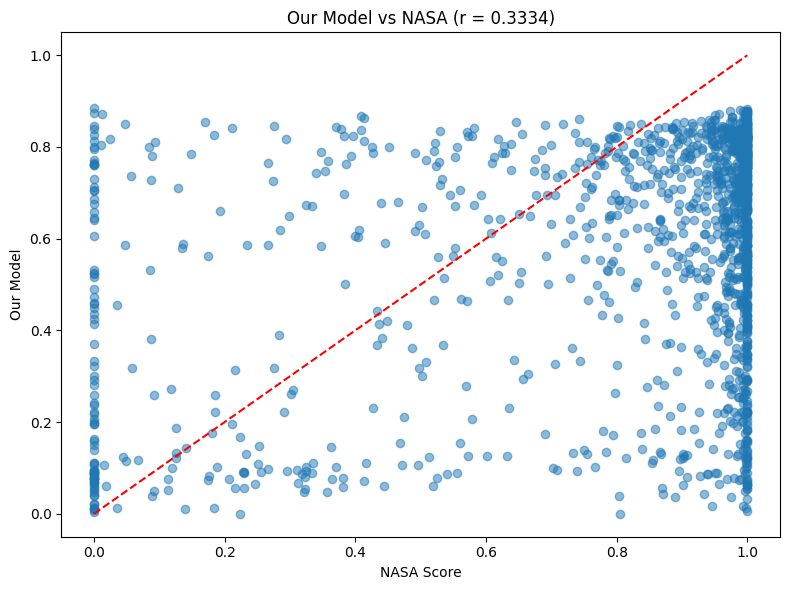

In [48]:
# Correlation
correlation = df_validation['planet_probability'].corr(df_validation['koi_score'])
print(f"Correlation with NASA: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_validation['koi_score'], df_validation['planet_probability'], alpha=0.5)
plt.xlabel('NASA Score')
plt.ylabel('Our Model')
plt.title(f'Our Model vs NASA (r = {correlation:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.tight_layout()
plt.show()

In [49]:
# Categorize agreement
df_validation['nasa_prediction'] = (df_validation['koi_score'] > 0.5).astype(int)
df_validation['our_prediction'] = (df_validation['planet_probability'] > 0.7).astype(int)

# Agreement matrix
agree_planet = ((df_validation['nasa_prediction'] == 1) & (df_validation['our_prediction'] == 1)).sum()
agree_fp = ((df_validation['nasa_prediction'] == 0) & (df_validation['our_prediction'] == 0)).sum()
we_say_planet = ((df_validation['nasa_prediction'] == 0) & (df_validation['our_prediction'] == 1)).sum()
nasa_says_planet = ((df_validation['nasa_prediction'] == 1) & (df_validation['our_prediction'] == 0)).sum()

print("Agreement Matrix:")
print(f"\n{'':25} {'NASA: Planet':>15} {'NASA: FP':>15}")
print("-" * 55)
print(f"{'Our Model: Planet':<25} {agree_planet:>15} {we_say_planet:>15}")
print(f"{'Our Model: FP':<25} {nasa_says_planet:>15} {agree_fp:>15}")

total = len(df_validation)
agreement_rate = (agree_planet + agree_fp) / total
print(f"\nOverall Agreement: {agreement_rate:.1%}")

Agreement Matrix:

                             NASA: Planet        NASA: FP
-------------------------------------------------------
Our Model: Planet                     529              53
Our Model: FP                         615             175

Overall Agreement: 51.3%


In [50]:
# Cases where we disagree most
df_validation['disagreement'] = abs(df_validation['planet_probability'] - df_validation['koi_score'])

# We say planet, NASA says no
we_say_yes = df_validation[
    (df_validation['our_prediction'] == 1) & 
    (df_validation['nasa_prediction'] == 0)
].sort_values('disagreement', ascending=False)

print(f"\nWe say Planet, NASA says FP ({len(we_say_yes)} cases):")
print(we_say_yes[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))

# NASA says planet, we say no
nasa_says_yes = df_validation[
    (df_validation['our_prediction'] == 0) & 
    (df_validation['nasa_prediction'] == 1)
].sort_values('disagreement', ascending=False)

print(f"\nNASA says Planet, we say FP ({len(nasa_says_yes)} cases):")
print(nasa_says_yes[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))


We say Planet, NASA says FP (53 cases):
kepoi_name  planet_probability  koi_score
 K03444.04            0.884572      0.000
 K04097.02            0.873287      0.000
 K03119.01            0.871694      0.013
 K01194.02            0.845474      0.000
 K03072.01            0.838396      0.000
 K02680.01            0.825678      0.000
 K03444.02            0.814031      0.000
 K05371.01            0.849160      0.048
 K01587.01            0.800735      0.000
 K04846.01            0.795656      0.000

NASA says Planet, we say FP (615 cases):
kepoi_name  planet_probability  koi_score
 K00971.01            0.006143      1.000
 K06401.01            0.012386      0.998
 K02093.03            0.016151      0.994
 K05566.01            0.032945      1.000
 K02548.01            0.054104      1.000
 K03811.01            0.050552      0.996
 K02813.01            0.057188      1.000
 K07865.01            0.036193      0.975
 K04546.01            0.062284      1.000
 K07430.01            0.062412     

In [51]:
# Both strongly agree it's a planet
strong_planets = df_validation[
    (df_validation['planet_probability'] > 0.85) &
    (df_validation['koi_score'] > 0.85)
].sort_values('planet_probability', ascending=False)

print(f"\nStrong Agreement - Likely Planets ({len(strong_planets)}):")
print(strong_planets[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))


Strong Agreement - Likely Planets (44):
kepoi_name  planet_probability  koi_score
 K05327.01            0.882640      1.000
 K08012.01            0.880085      0.989
 K01843.02            0.879401      0.974
 K02862.01            0.878216      0.993
 K01397.01            0.877891      1.000
 K06752.01            0.877775      1.000
 K02453.01            0.875788      1.000
 K03034.01            0.875775      1.000
 K04957.02            0.875414      0.997
 K00531.01            0.872267      1.000


In [52]:
# Look at features of disagreement cases
# We say yes, NASA says no
we_yes_nasa_no = df_candidates[df_candidates['kepoi_name'].isin(we_say_yes['kepoi_name'].head(10))]

# NASA says yes, we say no
nasa_yes_we_no = df_candidates[df_candidates['kepoi_name'].isin(nasa_says_yes['kepoi_name'].head(10))]

print("Features where WE say Planet, NASA says No:")
print(we_yes_nasa_no[['kepoi_name', 'koi_period', 'koi_depth', 'koi_prad', 'koi_model_snr']].to_string(index=False))

print("\nFeatures where NASA says Planet, WE say No:")
print(nasa_yes_we_no[['kepoi_name', 'koi_period', 'koi_depth', 'koi_prad', 'koi_model_snr']].to_string(index=False))

Features where WE say Planet, NASA says No:
kepoi_name  koi_period  koi_depth  koi_prad  koi_model_snr
 K01194.02   14.862308      840.0      1.57           14.4
 K01587.01   52.971584     3882.6     29.02           51.4
 K02680.01   14.407903     3058.0     23.40            7.7
 K03119.01    2.184438     1546.8      0.94           19.7
 K03072.01   24.336703      551.1      1.95           13.4
 K04097.02    4.449023       88.9      0.55           10.4
 K04846.01   19.254536      186.0      1.32            9.2
 K03444.02   60.326688     3146.7      4.98           57.0
 K05371.01   33.303788      272.4      1.14            8.1
 K03444.04   14.150231      208.1      0.74            9.3

Features where NASA says Planet, WE say No:
kepoi_name  koi_period  koi_depth  koi_prad  koi_model_snr
 K00971.01    0.533059     1495.8    133.56          179.6
 K02548.01    0.827151      272.4     19.10            8.1
 K02813.01    0.698461      134.4     14.81           16.1
 K04546.01    0.741768    

In [53]:
# Compare median features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_model_snr']

we_yes_nasa_no_features = df_candidates[df_candidates['kepoi_name'].isin(we_say_yes['kepoi_name'])]
nasa_yes_we_no_features = df_candidates[df_candidates['kepoi_name'].isin(nasa_says_yes['kepoi_name'])]
both_agree = df_candidates[df_candidates['kepoi_name'].isin(strong_planets['kepoi_name'])]

print(f"{'Feature':<15} {'Both Agree':>12} {'We Yes/NASA No':>15} {'NASA Yes/We No':>15}")
print("-" * 60)
for col in feature_cols:
    agree_med = both_agree[col].median()
    we_med = we_yes_nasa_no_features[col].median()
    nasa_med = nasa_yes_we_no_features[col].median()
    print(f"{col:<15} {agree_med:>12.2f} {we_med:>15.2f} {nasa_med:>15.2f}")

Feature           Both Agree  We Yes/NASA No  NASA Yes/We No
------------------------------------------------------------
koi_period              7.10           24.34            9.55
koi_depth             328.50          370.50          152.00
koi_duration            2.09            3.46            4.11
koi_prad                1.14            1.58            1.73
koi_model_snr          11.55           10.40           12.50


In [54]:
# Save validation results
df_validation.to_csv("../results/validation_vs_nasa.csv", index=False)

# Summary stats
summary = {
    'Total Candidates Evaluated': len(df_validation),
    'Agreement Rate': f"{agreement_rate:.1%}",
    'Strong Planet Candidates': len(strong_planets),
    'Correlation with NASA': f"{correlation:.4f}",
    'Our Model Precision (vs NASA)': f"{agree_planet / (agree_planet + we_say_planet):.1%}",
    'Our Model Recall (vs NASA)': f"{agree_planet / (agree_planet + nasa_says_planet):.1%}"
}

print("\n=== Final Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")


=== Final Summary ===
Total Candidates Evaluated: 1372
Agreement Rate: 51.3%
Strong Planet Candidates: 44
Correlation with NASA: 0.3334
Our Model Precision (vs NASA): 90.9%
Our Model Recall (vs NASA): 46.2%


In [55]:
# Save models and results
torch.save(model_v3.state_dict(), "../models/exoplanet_nn_v3.pt")

# Save strong candidates list
strong_planets_full = df_candidates[df_candidates['kepoi_name'].isin(strong_planets['kepoi_name'])]
strong_planets_full.to_csv("../results/strong_planet_candidates.csv", index=False)

print(f"Saved {len(strong_planets_full)} strong candidates to results/strong_planet_candidates.csv")

Saved 44 strong candidates to results/strong_planet_candidates.csv


In [56]:
# Adding more features to improve model performance
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=*&format=csv"

df_full = pd.read_csv(f"{url}?{params}", low_memory=False)

print(f"Total columns: {len(df_full.columns)}")
print(f"\nColumns:")
for col in sorted(df_full.columns):
    print(f"  {col}")

Total columns: 153

Columns:
  dec
  dec_err
  dec_str
  kepid
  kepler_name
  kepoi_name
  koi_bin_oedp_sig
  koi_comment
  koi_count
  koi_datalink_dvr
  koi_datalink_dvs
  koi_delivname
  koi_depth
  koi_depth_err1
  koi_depth_err2
  koi_dicco_mdec
  koi_dicco_mdec_err
  koi_dicco_mra
  koi_dicco_mra_err
  koi_dicco_msky
  koi_dicco_msky_err
  koi_dikco_mdec
  koi_dikco_mdec_err
  koi_dikco_mra
  koi_dikco_mra_err
  koi_dikco_msky
  koi_dikco_msky_err
  koi_disp_prov
  koi_disposition
  koi_dor
  koi_dor_err1
  koi_dor_err2
  koi_duration
  koi_duration_err1
  koi_duration_err2
  koi_eccen
  koi_eccen_err1
  koi_eccen_err2
  koi_fittype
  koi_fpflag_co
  koi_fpflag_ec
  koi_fpflag_nt
  koi_fpflag_ss
  koi_fwm_pdeco
  koi_fwm_pdeco_err
  koi_fwm_prao
  koi_fwm_prao_err
  koi_fwm_sdec
  koi_fwm_sdec_err
  koi_fwm_sdeco
  koi_fwm_sdeco_err
  koi_fwm_sra
  koi_fwm_sra_err
  koi_fwm_srao
  koi_fwm_srao_err
  koi_fwm_stat_sig
  koi_gmag
  koi_gmag_err
  koi_hmag
  koi_hmag_err
  koi_imag


In [57]:
# Expanded feature set
feature_cols = [
    # Transit properties (current)
    'koi_period',       # Orbital period
    'koi_depth',        # Transit depth
    'koi_duration',     # Transit duration
    'koi_prad',         # Planet radius
    'koi_teq',          # Equilibrium temperature
    'koi_insol',        # Insolation flux
    'koi_model_snr',    # Signal-to-noise
    
    # Star properties (current)
    'koi_steff',        # Star temperature
    'koi_srad',         # Star radius
    
    # New: More star properties
    'koi_slogg',        # Star surface gravity
    'koi_smass',        # Star mass
    'koi_smet',         # Star metallicity
    
    # New: Transit shape
    'koi_impact',       # Impact parameter
    'koi_ror',          # Planet/star radius ratio
    'koi_dor',          # Semi-major axis / star radius
    'koi_incl',         # Orbital inclination
    'koi_ingress',      # Ingress duration
    'koi_num_transits', # Number of transits observed
    
    # New: False positive flags (very useful!)
    'koi_fpflag_nt',    # Not transit-like
    'koi_fpflag_ss',    # Stellar eclipse
    'koi_fpflag_co',    # Centroid offset
    'koi_fpflag_ec',    # Ephemeris match
    
    # New: Quality indicators
    'koi_max_mult_ev',  # Max multiple event statistic
    'koi_max_sngle_ev', # Max single event statistic
    'koi_model_chisq',  # Chi-square of model fit
    'koi_kepmag',       # Kepler magnitude (brightness)
]

print(f"Total features: {len(feature_cols)}")

Total features: 26


In [60]:
# Check which columns actually exist
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&format=csv"
df = pd.read_csv(f"{url}?{params}", low_memory=False)

# Test which features exist
test_features = [
    'koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_teq',
    'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_srad', 'koi_slogg',
    'koi_smass', 'koi_smet', 'koi_impact', 'koi_ror', 'koi_dor', 
    'koi_incl', 'koi_ingress', 'koi_num_transits', 'koi_fpflag_nt',
    'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_max_mult_ev',
    'koi_max_sngle_ev', 'koi_model_chisq', 'koi_kepmag'
]

print("Available features:")
for f in test_features:
    exists = f in df.columns
    count = df[f].notna().sum() if exists else 0
    print(f"  {f:<20} ({count} values)")

Available features:
  koi_period           (9564 values)
  koi_depth            (9201 values)
  koi_duration         (9564 values)
  koi_prad             (9201 values)
  koi_teq              (9201 values)
  koi_insol            (9243 values)
  koi_model_snr        (9201 values)
  koi_steff            (9201 values)
  koi_srad             (9201 values)
  koi_slogg            (9201 values)
  koi_smass            (0 values)
  koi_smet             (0 values)
  koi_impact           (9201 values)
  koi_ror              (0 values)
  koi_dor              (0 values)
  koi_incl             (0 values)
  koi_ingress          (0 values)
  koi_num_transits     (0 values)
  koi_fpflag_nt        (9564 values)
  koi_fpflag_ss        (9564 values)
  koi_fpflag_co        (9564 values)
  koi_fpflag_ec        (9564 values)
  koi_max_mult_ev      (0 values)
  koi_max_sngle_ev     (0 values)
  koi_model_chisq      (0 values)
  koi_kepmag           (9563 values)


In [61]:
# Redo data prep getting rid of unused columns
feature_cols = [
    # Transit properties
    'koi_period',
    'koi_depth',
    'koi_duration',
    'koi_prad',
    'koi_teq',
    'koi_insol',
    'koi_model_snr',
    
    # Star properties
    'koi_steff',
    'koi_srad',
    'koi_slogg',
    
    # Transit shape
    'koi_impact',
    
    # False positive flags (new!)
    'koi_fpflag_nt',
    'koi_fpflag_ss',
    'koi_fpflag_co',
    'koi_fpflag_ec',
    
    # Brightness
    'koi_kepmag',
]

print(f"Total features: {len(feature_cols)}")

Total features: 16


In [62]:
# Redoing cleaning

# Filter to confirmed and false positives
df = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df['label'] = (df['koi_disposition'] == 'CONFIRMED').astype(int)

# Drop rows with missing features
df_clean = df.dropna(subset=feature_cols)

X = df_clean[feature_cols].values
y = df_clean['label'].values

print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Planets: {sum(y==1)}, FP: {sum(y==0)}")

Samples: 7325
Features: 16
Planets: 2744, FP: 4581


In [63]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Train: 5860, Test: 1465
Features: 16


In [64]:
class ExoplanetNNv4(nn.Module):
    def __init__(self, input_size=16):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train
model_v4 = ExoplanetNNv4(input_size=len(feature_cols))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_v4.parameters(), lr=0.001)

for epoch in range(100):
    model_v4.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_v4(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {total_loss/len(train_loader):.4f}")

Epoch 20/100, Loss: 0.0545
Epoch 40/100, Loss: 0.0402
Epoch 60/100, Loss: 0.0361
Epoch 80/100, Loss: 0.0367
Epoch 100/100, Loss: 0.0356


In [65]:
model_v4.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v4(X_batch)
        all_probs.extend(outputs.numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Test different thresholds
print("Threshold | Accuracy | Precision | Recall | F1")
print("-" * 50)
for thresh in [0.5, 0.6, 0.7, 0.8]:
    preds = (all_probs > thresh).astype(float)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds)
    rec = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    print(f"   {thresh}     |  {acc:.4f}  |  {prec:.4f}   | {rec:.4f} | {f1:.4f}")

Threshold | Accuracy | Precision | Recall | F1
--------------------------------------------------
   0.5     |  0.9939  |  0.9909   | 0.9927 | 0.9918
   0.6     |  0.9939  |  0.9927   | 0.9909 | 0.9918
   0.7     |  0.9945  |  0.9945   | 0.9909 | 0.9927
   0.8     |  0.9939  |  0.9945   | 0.9891 | 0.9918


In [66]:
# Seems too good to be true, likely overfitting with so many features 
# further tests to see how much FP flags contribute

feature_cols_no_flags = [
    'koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_teq',
    'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_srad', 'koi_slogg',
    'koi_impact', 'koi_kepmag'
]

X_no_flags = df_clean[feature_cols_no_flags].values

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(
    X_no_flags, y, test_size=0.2, random_state=42, stratify=y
)

scaler_nf = StandardScaler()
X_train_nf = scaler_nf.fit_transform(X_train_nf)
X_test_nf = scaler_nf.transform(X_test_nf)

# Quick train
train_dataset_nf = ExoplanetDataset(X_train_nf, y_train_nf)
train_loader_nf = DataLoader(train_dataset_nf, batch_size=32, shuffle=True)

model_no_flags = ExoplanetNNv4(input_size=12)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_no_flags.parameters(), lr=0.001)

for epoch in range(100):
    model_no_flags.train()
    for X_batch, y_batch in train_loader_nf:
        outputs = model_no_flags(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate
model_no_flags.eval()
X_test_tensor = torch.tensor(X_test_nf, dtype=torch.float32)
with torch.no_grad():
    probs = model_no_flags(X_test_tensor).numpy()

preds = (probs > 0.7).astype(float)
print(f"Without FP flags:")
print(f"  Accuracy:  {accuracy_score(y_test_nf, preds):.4f}")
print(f"  Precision: {precision_score(y_test_nf, preds):.4f}")
print(f"  Recall:    {recall_score(y_test_nf, preds):.4f}")
print(f"  F1:        {f1_score(y_test_nf, preds):.4f}")


Without FP flags:
  Accuracy:  0.8614
  Precision: 0.8745
  Recall:    0.7359
  F1:        0.7992


In [67]:
print("Basically: Including the FP flags greatly improves model performance")
print("because it is basically giving us the answer from NASA")
print("")
print("The version 4 model without the flags is better representative of the machine learning that has been performed")
print("Going to save both versions for reference")

Basically: Including the FP flags greatly improves model performance
because it is basically giving us the answer from NASA

The version 4 model without the flags is better representative of the machine learning that has been performed
Going to save both versions for reference


In [68]:
# Save V4 with flags (best performance)
torch.save(model_v4.state_dict(), "../models/exoplanet_nn_v4_with_flags.pt")

# Save V4 without flags (pure ML)
torch.save(model_no_flags.state_dict(), "../models/exoplanet_nn_v4_no_flags.pt")

# Save scaler
with open("../models/scaler_v4.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Models saved.")

Models saved.


          Model  Features  Accuracy     F1
             V1         3    0.8076 0.7531
             V2         3    0.8165 0.7675
             V3         9    0.8581 0.8295
  V4 (no flags)        12    0.8614 0.7992
V4 (with flags)        16    0.9945 0.9927


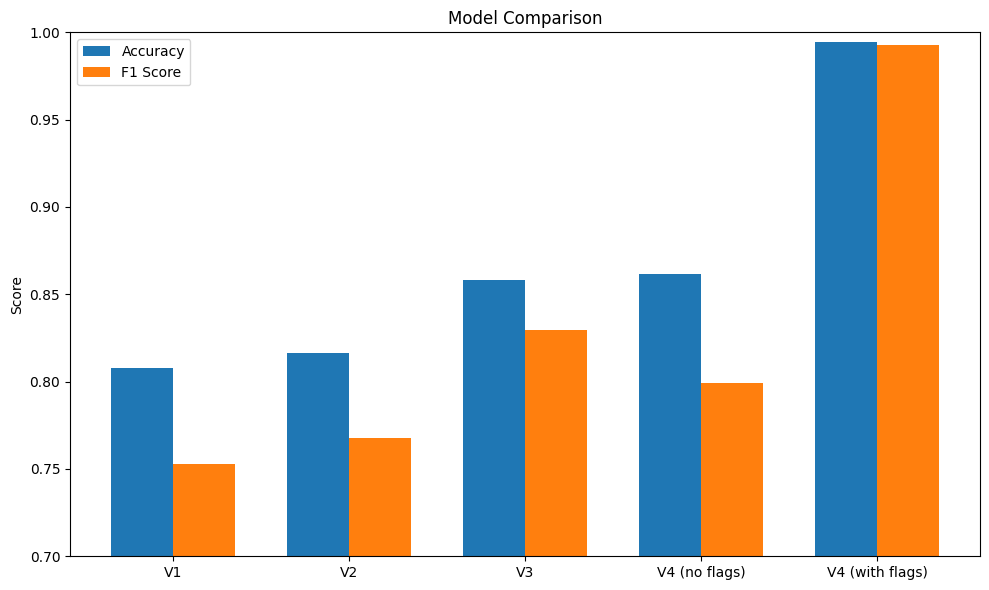

In [69]:
# Updated comparisons
results = {
    'Model': ['V1', 'V2', 'V3', 'V4 (no flags)', 'V4 (with flags)'],
    'Features': [3, 3, 9, 12, 16],
    'Accuracy': [0.8076, 0.8165, 0.8581, 0.8614, 0.9945],
    'F1': [0.7531, 0.7675, 0.8295, 0.7992, 0.9927]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.35

bars1 = ax.bar(x - width/2, results['Accuracy'], width, label='Accuracy')
bars2 = ax.bar(x + width/2, results['F1'], width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim(0.7, 1.0)

plt.tight_layout()
plt.show()